<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: Прогнозирование временных рядов</center></h2>

<h3><center>Выполнила Шеневская Влада</center></h3>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

В качестве основного источника к выполнению этого домашнего задания использовала книгу "Introductory Econometrics For Finance" by Chris Brooks, 4th edition

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

In [1]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


In [2]:
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Задание 1 (1 балл). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекомендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [ ]:
# скачаем данные -- данные были взяты из рекомендуемого источника: https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc 
!wget https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Brent%20Spot%20Price.csv # спот цены Brent, Monthly
!wget https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Nuclear%20Capacity.csv  # US nuclear capacity, Daily

In [4]:
url1 = "https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Brent%20Spot%20Price.csv" # Brent Spot Price (M)
url2 = "https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Nuclear%20Capacity.csv" # US nuclear capacity (D)

In [5]:
# считаем файлы
ts1 = pd.read_csv(url1)
ts2 = pd.read_csv(url2)

In [6]:
ts1.head()

,Unnamed: 0,"Brent crude oil spot price, Monthly (dollars per barrel)"
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352


In [7]:
ts2.head()

,Unnamed: 0,"U.S. nuclear capacity, daily (Megawatts)"
0,2007 0101 01,101764.9
1,2007 0102 02,101764.9
2,2007 0103 03,101764.9
3,2007 0104 04,101764.9
4,2007 0105 05,101764.9


In [8]:
# переменуем название колонок
ts1.columns = ['date', 'price']
ts2.columns = ['date', 'capacity']

In [9]:
# в каком то странном формате записана дневная дата, переведем к нормальному формату простыми срезами (год - месяц - день)
x = pd.DataFrame() 
for i in ts2.date:
  i = i[:7] + " " + i[7:9]
  x  = x.append(pd.Series(i), ignore_index=True)
x  

,0
0,2007 01 01
1,2007 01 02
2,2007 01 03
3,2007 01 04
4,2007 01 05
...,...
5220,2021 04 17
5221,2021 04 18
5222,2021 04 19
5223,2021 04 20


In [10]:
ts3 = pd.concat([ts2, x.reindex(ts2.index)], axis=1)

In [11]:
ts3 = ts3.rename(columns={"date": "raw date", 0:"date"})

In [12]:
# приведем месячные данные к соответствующему формату
ts1.date = pd.DatetimeIndex(ts1.date)
ts1 = ts1.sort_values(by = "date")
ts1.index = pd.PeriodIndex(ts1.date, freq='M')

In [13]:
# приведем дневные данные к соответствующему формату
ts3.date = pd.DatetimeIndex(ts3.date)
ts3 = ts3.sort_values(by = "date")
ts3.index = pd.PeriodIndex(ts3.date, freq='D')

In [14]:
ts3 = ts3.drop(columns=['raw date']) # выкинем эту колонку, тк она нам не нужна больше, оставляем ту, где данные приведены к нужному формату

In [15]:
ts1.isna().sum() # проверили, что нет пропусков в данных

date     0
price    0
dtype: int64

In [16]:
ts3.isna().sum() # проверили, что нет пропусков в данных

capacity    0
date        0
dtype: int64

**0.1 Brent crude oil spot price**

Для работы с временными рядами в финансах чаще всего используются темпы прироста (growth rates) нежели значения цены (index levels), поэтому преобразуем в логарифмические темпы прироста и будем позже работать с ними (используем логарифмические темпы прироста вместо обычных, чтобы воспользоваться свойством аддитивности)

Но таким образом мы получаем first difference для логарифмированного ряда (априори даже trend-stationary ряд станет стационарным после взятия первой разницы)

In [17]:
ts1_returns = np.log(ts1['price']).pct_change()

In [18]:
ts1.index # index - date

PeriodIndex(['1990-01', '1990-02', '1990-03', '1990-04', '1990-05', '1990-06',
             '1990-07', '1990-08', '1990-09', '1990-10',
             ...
             '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
             '2022-09', '2022-10', '2022-11', '2022-12'],
            dtype='period[M]', name='date', length=396)

In [19]:
pd.DataFrame(ts1_returns).index # date выступает индексом 

PeriodIndex(['1990-01', '1990-02', '1990-03', '1990-04', '1990-05', '1990-06',
             '1990-07', '1990-08', '1990-09', '1990-10',
             ...
             '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
             '2022-09', '2022-10', '2022-11', '2022-12'],
            dtype='period[M]', name='date', length=396)

In [20]:
ts1_returns = pd.DataFrame(ts1_returns).rename(columns={'price':'value'})

In [21]:
ts1 = pd.concat([ts1, ts1_returns.reindex(ts1.index)], axis=1)

**0.2 U.S. nuclear capacity**

Наблюдаем большие значения capacity, для того чтобы приблизить к нормальному распределению и работать с более удобными цифрами логарифмируем ряд, но не будем считать returns (нет особой экономической интуиции за тем, чтобы считать returns для capacity ядерной электростанции)

In [22]:
ts3['capacityLog'] = np.log(ts3.capacity)

**train test split**

В тестовую выборку откладываем 20% наблюдений




In [23]:
test_size_ts1 = int(ts1.shape[0] * 0.2)
test_size_ts3 = int(ts3.shape[0] * 0.2) 

train_df_ts1 = ts1[:-test_size_ts1]
test_df_ts1  = ts1[-test_size_ts1:]

train_df_ts3 = ts3[:-test_size_ts3]
test_df_ts3  = ts3[-test_size_ts3:]

## Задание 2. Анализ временных рядов (1 балл).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики [автокорреляционных функций](https://www.machinelearningmastery.ru/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788/) для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

**Визуализация временных рядов**

**1.1 Brent crude oil spot price**

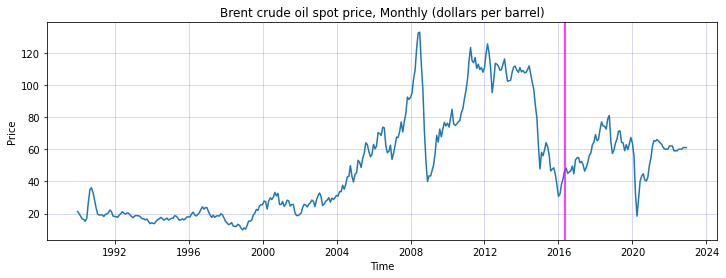

In [ ]:
# отрисуем временные ряды Brent crude oil spot price
plt.figure(figsize=(12, 4))
plt.plot(ts1.date, ts1.price)
plt.axvline(x = ts1[:-test_size_ts1].date[-1], c='magenta')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Brent crude oil spot price, Monthly (dollars per barrel)')
plt.grid(color='b', alpha=0.2)
plt.show()

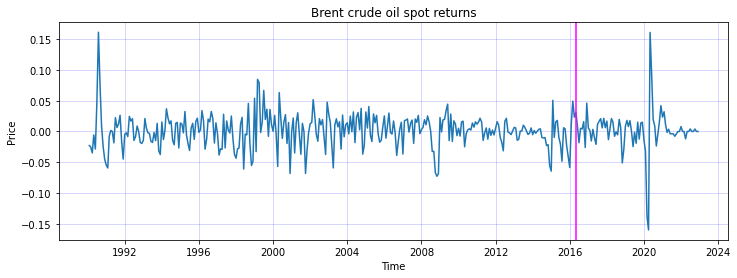

In [ ]:
# отрисуем временные ряды Brent crude oil spot price для price returns
plt.figure(figsize=(12, 4))
plt.plot(ts1.date, ts1.value)
plt.axvline(x = ts1[:-test_size_ts1].date[-1], c='magenta')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Brent crude oil spot returns')
plt.grid(color='b', alpha=0.2)
plt.show()
# ряд очень похож на стационарный

**1.2 U.S. nuclear capacity**

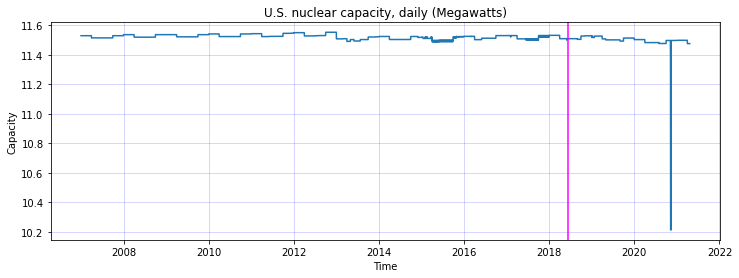

In [ ]:
# отрисуем временные ряды U.S. nuclear capacity
plt.figure(figsize=(12, 4))
plt.plot(ts3.date, ts3.capacityLog)
plt.axvline(x = ts3[:-test_size_ts3].date[-1], c='magenta')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.title('U.S. nuclear capacity, daily (Megawatts)')
plt.grid(color='b', alpha=0.2)
plt.show()

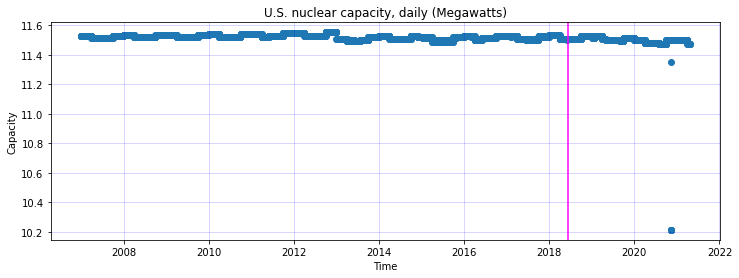

In [ ]:
# чтобы посмотреть из-за чего был такой сильный скачок в 2021 
plt.figure(figsize=(12, 4))
plt.scatter(ts3.date, ts3.capacityLog)
plt.axvline(x = ts3[:-test_size_ts3].date[-1], c='magenta')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.title('U.S. nuclear capacity, daily (Megawatts)')
plt.grid(color='b', alpha=0.2)
plt.show()

**Графики автокорреляционных функций**

**2.1 Brent Oil Spot Price**

Используемые источники: 

http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf 

In [ ]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')

Чтобы посчитать автокорреляции и частичные автокорреляции все же буду использовать уже встроенные функции, которые позволяют также строить красивые графики

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

Проведем Ljung-Box Test, чтобы понять есть ли автокорреляция

In [ ]:
import statsmodels

In [ ]:
statsmodels.stats.diagnostic.acorr_ljungbox(ts1.price, lags=30) # посчитаем для 30 лагов, берем наш ряд с price returns

,lb_stat,lb_pvalue
1,388.819785,1.495590e-86
2,761.600139,4.174756e-166
3,1117.020683,7.385834e-242
4,1456.506638,0.000000e+00
5,1782.162409,0.000000e+00
6,2095.146002,0.000000e+00
7,2397.250992,0.000000e+00
8,2689.882325,0.000000e+00
9,2974.598766,0.000000e+00
10,3252.781067,0.000000e+00


Начиная с первого лага замечаем, что pvalue крайне маленький, следовательно, не можем отвергнуть гипотезу о том, что присутствует автокорреляция (H1)

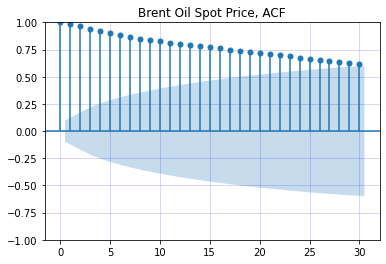

In [ ]:
sm.graphics.tsa.plot_acf(ts1.price, lags=30)
plt.title('Brent Oil Spot Price, ACF') # ACF
plt.grid(alpha=0.2, c='b')
plt.show();

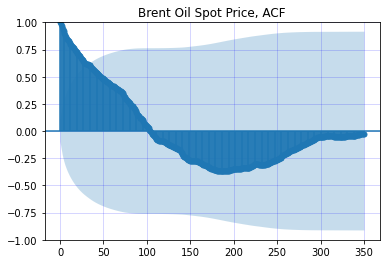

In [ ]:
sm.graphics.tsa.plot_acf(ts1.price, lags=350)
plt.title('Brent Oil Spot Price, ACF') # ACF
plt.grid(alpha=0.2, c='b')
plt.show();

примерно 100 дней составляет длина сезонного тренда (длина стороны треугольника до того, как происходит излом acf на графике)

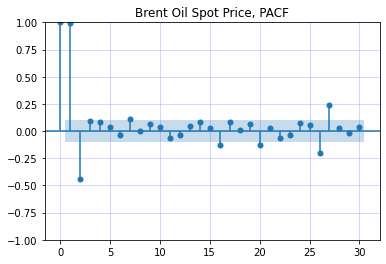

In [ ]:
sm.graphics.tsa.plot_pacf(ts1.price, lags=30, method='yw')
plt.title('Brent Oil Spot Price, PACF') # PACF
plt.grid(alpha=0.2, c='b')
plt.show();

Скорее всего acf и pacf предложенного ряда соответствуют AR(3), где acf (геометрически убывает) и pacf (незначим после 3 лага).

The larger the amplitude of seasonal fluctuations, the more pronounced
the oscillations are in the ACF. 

Чем больше сезонные колебания, тем более заметные осциляции в acf, здесь наблюдается постепенное затухание acf

для того, чтобы реализовать предложенным способом через np.correlate: https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation  

Но мне удобнее использованный мною способ, ведь он также является верным

**2.2 U.S. nuclear capacity**

In [ ]:
statsmodels.stats.diagnostic.acorr_ljungbox(ts3['capacity'], lags=30)

,lb_stat,lb_pvalue
1,4173.340083,0.0
2,7258.638897,0.0
3,9428.016883,0.0
4,10843.487933,0.0
5,11665.990217,0.0
6,12392.023550,0.0
7,13114.257630,0.0
8,13825.104074,0.0
9,14523.582931,0.0
10,15213.565025,0.0


Гипотезу о том, что присутствует автокорреляция (H1) не можем отвергнуть 

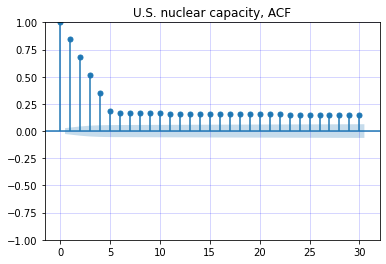

In [ ]:
sm.graphics.tsa.plot_acf(ts3.capacityLog, lags=30) # ACF
plt.title('U.S. nuclear capacity, ACF') 
plt.grid(alpha=0.2, c='b')
plt.show()

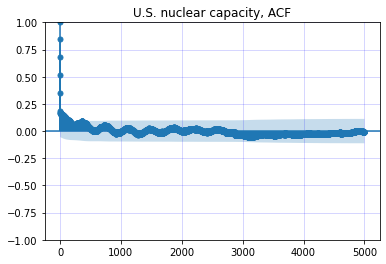

In [ ]:
sm.graphics.tsa.plot_acf(ts3.capacityLog, lags=5000) # ACF
plt.title('U.S. nuclear capacity, ACF') 
plt.grid(alpha=0.2, c='b')
plt.show()

Если взять лаги почти всех наблюдений, то сезонность можно выделить, как 200 дней

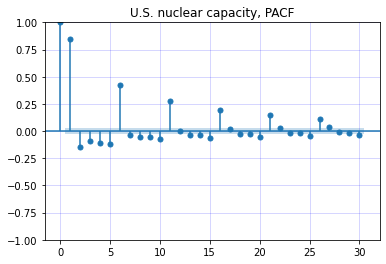

In [ ]:
sm.graphics.tsa.plot_pacf(ts3.capacityLog, lags=30, method='yw') # using the default Yule-Walker method with sample-size adjustment in denominator for acovf
plt.title('U.S. nuclear capacity, PACF')  # PACF
plt.grid(alpha=0.2, c='b')
plt.show()

Скорее всего смешанный ARMA процесс

**Декомпозиция временного ряда**

**Нестационарные процессы:**
> Процесс с детерминистическим трендом 

> Процесс случайного блуждания


**N.B.**

In general, it is not easy to visually differentiate between the trend and random walk. Even when the series is trend-nonstationary, taking the first-differerence will make the series stationary (bad then we have noninvertible MA process with unwanted properties, it cannot be expressed as an autoregressive process). So testing for a unit root will not allow to disentangle the two.

Typically, people estimate a trend, and then do a unit root test on detrended data to find out whether it was difference stationary (basically, run the regression on t and then take the residuals as a detrended data). If detrended data is stationary, than you can regard the series as trend-stationary. Otherwise, it will be difference-stationary. 

С помощью теста Дики-Фуллера проверим стационарность (unit root test)

In [ ]:
test = sm.tsa.adfuller(ts1.price)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -2.3662084811231265
p-value:  0.15150178029715095
Critical values:  {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Есть единичные корни, ряд не стационарен


In [ ]:
test2 = sm.tsa.adfuller(ts3.capacityLog)
print('adf: ', test2[0])
print('p-value: ', test2[1])
print('Critical values: ', test2[4])
if test2[0]> test2[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -7.688353255459419
p-value:  1.4413233374934528e-11
Critical values:  {'1%': -3.4316098758663207, '5%': -2.8620967334513945, '10%': -2.5670663491085057}
Единичных корней нет, ряд стационарен


In [ ]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

3.1 Brent Oil Spot Price

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
ts1.index = ts1.index.to_timestamp()

Мультипликативная декомпозиция

In [ ]:
decomposition = seasonal_decompose(ts1.price, model = "multiplicative")

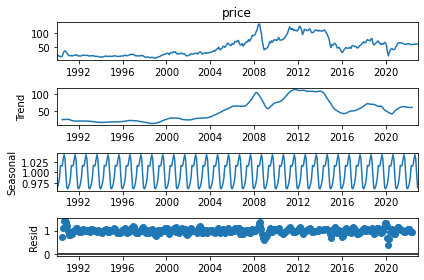

In [ ]:
decomposition.plot();

In [ ]:
trend = decomposition.trend.replace(np.nan, 0)
seasonal = decomposition.seasonal.replace(np.nan, 0)
residual = decomposition.resid.replace(np.nan, 0)

In [ ]:
ts1["priceDecomp"] = trend + seasonal

In [ ]:
from sklearn.metrics import mean_squared_error
rmse1 = (mean_squared_error(ts1["priceDecomp"], ts1["price"]))**(1/2)

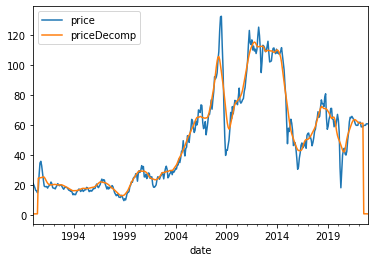

In [ ]:
ts1.plot(kind="line", x="date", y = ["price","priceDecomp"]);

Аддитивная декомпозиция

In [ ]:
decomposition2 = seasonal_decompose(ts1.price, model = "additive")

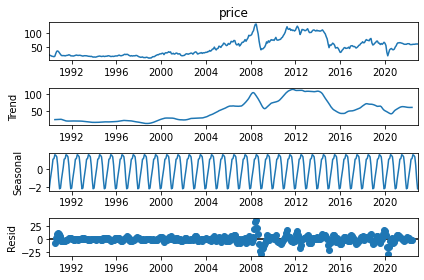

In [ ]:
decomposition2.plot();

In [ ]:
trend2 = decomposition2.trend.replace(np.nan, 0)
seasonal2 = decomposition2.seasonal.replace(np.nan, 0)
residual2 = decomposition2.resid.replace(np.nan, 0)

In [ ]:
ts1["priceDecomp2"] = trend2 + seasonal2

In [ ]:
rmse2 = (mean_squared_error(ts1["priceDecomp2"], ts1["price"]))**(1/2)

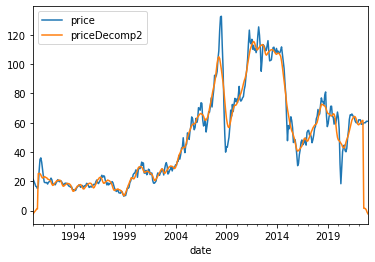

In [ ]:
ts1.plot(kind="line", x="date", y = ["price","priceDecomp2"]);

In [ ]:
print(f'Additive decomposition: {round(rmse2,4)} and Multiplicative decomposition: {round(rmse1,4)}')

Additive decomposition: 9.767 and Multiplicative decomposition: 9.7889


С незначительной разностью мультипликативная декомпозиция оказалась лучше

3.2 U.S. nuclear capacity

In [ ]:
ts3.index = ts3.index.to_timestamp()

In [ ]:
decomposition3 = seasonal_decompose(ts3.capacityLog, model = "additive")

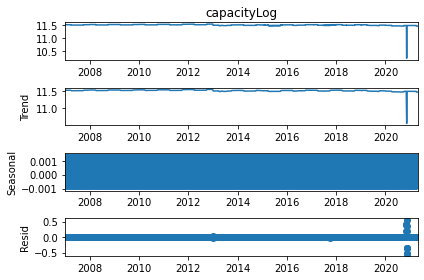

In [ ]:
decomposition3.plot();

In [ ]:
trend3 = decomposition3.trend.replace(np.nan, 0)
seasonal3 = decomposition3.seasonal.replace(np.nan, 0)
residual3 = decomposition3.resid.replace(np.nan, 0)

In [ ]:
ts3["capacityDecomp"] = trend3 + seasonal3 

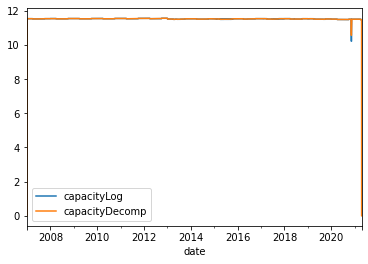

In [ ]:
ts3.plot(kind="line", x="date", y = ["capacityLog","capacityDecomp"]);

In [ ]:
rmse3 = (mean_squared_error(ts3["capacityDecomp"], ts3["capacityLog"]))**(1/2)

In [ ]:
print(f'Additive decomposition: {round(rmse3,4)}')

Additive decomposition: 0.3903


## Задание 3. Предсказание месячного временного ряда (4 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной ряд несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.

### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

Использованные материалы: 

https://www.youtube.com/watch?v=nteG6yRHy2E 

https://datascience.stackexchange.com/questions/58473/making-predictions-from-detrended-data

https://machinelearningmastery.com/time-series-trends-in-python/ 

Рассмотрим, какого типа была нестационарность

In [70]:
ts1["timeIndex"] = ts1.date - ts1.date.min()
ts1["timeIndex"] =  ts1["timeIndex"]/np.timedelta64(1, 'M')
ts1["timeIndex"] = ts1["timeIndex"].round(0).astype(int)

In [71]:
model_linear = smf.ols('price ~ timeIndex', data = ts1).fit()

In [72]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     292.1
Date:                Sat, 23 Apr 2022   Prob (F-statistic):           2.18e-49
Time:                        21:47:38   Log-Likelihood:                -1818.6
No. Observations:                 396   AIC:                             3641.
Df Residuals:                     394   BIC:                             3649.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.1236      2.403      5.878      0.000       9.400      18.847
timeIndex      0.1799      0.011     17.089      0.000       0.159       0.201
==============================================================================
Omnibus:                       51.232   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.498
Skew:                           0.978   Prob(JB):                     2.20e-15
Kurtosis:                       3.512   Cond. No.                         456.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Trend

In [73]:
model_predict = model_linear.predict()

Detrended data -- residuals 

In [ ]:
model_linear.resid 

date
1990-01     7.127431
1990-02     5.509494
1990-03     3.903556
1990-04     1.948619
1990-05     1.508681
             ...    
2022-08   -24.479171
2022-09   -24.659109
2022-10   -23.839046
2022-11   -24.018984
2022-12   -24.198921
Freq: M, Length: 396, dtype: float64

In [ ]:
test = sm.tsa.adfuller(model_linear.resid)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -2.937817555882201
p-value:  0.04112376641380093
Critical values:  {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Единичных корней нет, ряд стационарен


Следовательно, ряд тренд-стационарный и следует работать с детрендированными данными, а потом уже добавить обратно трендовую составляющую

In [ ]:
ts1_detrend = model_linear.resid

In [ ]:
ts1_detrend = pd.DataFrame(ts1_detrend).rename(columns={0:"level"})

In [ ]:
ts1_detrend = pd.concat([ts1.date.reindex(ts1.index), ts1_detrend,], axis=1)

In [ ]:
ts1_detrend.index = pd.PeriodIndex(ts1_detrend.index, freq="M")

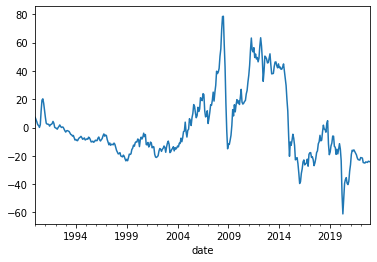

In [ ]:
ts1_detrend.level.plot();

In [ ]:
train_df_ts1_detrend = ts1_detrend[:-test_size_ts1]
test_df_ts1_detrend  = ts1_detrend[-test_size_ts1:]

**$\hat{y}_{t+1} = y_{t}$**




In [ ]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(train_df_ts1_detrend)
# ваш код обучения моделей здесь

NaiveForecaster()

In [ ]:
i = 0
fh1 = []
for i in range(test_size_ts1):
  i += 1
  fh1.append(i)

In [ ]:
y_pred = forecaster.predict(fh=fh1)

In [ ]:
output = np.array(y_pred[1]) + model_predict[-test_size_ts1:] # необходимо обратно вернуть тренд

In [ ]:
# посчитайте метрики на test

In [60]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(np.array(test_df_ts1.price),output)

8.940593551038967

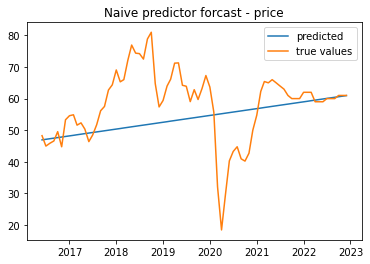

In [ ]:
plt.plot(test_df_ts1['date'], output, label='predicted')
plt.plot(test_df_ts1['date'], test_df_ts1.price, label='true values')
plt.legend()
plt.title("Naive predictor forcast - price");

Как упоминалось ранее при работе с финансовыми данными лучше всего анализировать returns, так сделаем это, тк каждый раз добавлять тренд неудобно, особых сложностей из-за того что возможно, что returns являются необратимым MA процессом (тк брали first difference) не должно возникнуть 

In [ ]:
test = sm.tsa.adfuller(ts1.value[1:])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
     print('Есть единичные корни, ряд не стационарен')
else:
     print('Единичных корней нет, ряд стационарен')

adf:  -11.494634463190021
p-value:  4.646273220940212e-21
Critical values:  {'1%': -3.4471856790801514, '5%': -2.868960436182993, '10%': -2.5707229006220524}
Единичных корней нет, ряд стационарен


Ряд returns стационарный, что можно было еще сказать по графику returns

In [ ]:
train_df_ts1.dropna(inplace = True) # убираем пропуски (1 месяц)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
forecaster2 = NaiveForecaster(strategy="last")
forecaster2.fit(train_df_ts1.value)

NaiveForecaster()

In [ ]:
y_pred2 = forecaster2.predict(fh=fh1)

In [ ]:
print(f"Mean absolute error of Naive predictor: {np.round(mean_absolute_error(np.array(test_df_ts1.value),y_pred2),3)}")

Mean absolute error of Naive predictor: 0.035


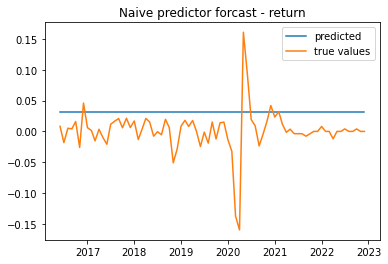

In [ ]:
plt.plot(test_df_ts1['date'], y_pred2.values, label='predicted')
plt.plot(test_df_ts1['date'], test_df_ts1.value, label='true values')
plt.legend()
plt.title("Naive predictor forcast - return");

**$\hat{y}_{t+1} = y_{t-seasonality+1}$**

In [ ]:
forecaster_seas = NaiveForecaster(strategy="mean", window_length=20, sp=15)

In [ ]:
forecaster_seas.fit(train_df_ts1.value)

NaiveForecaster(sp=15, strategy='mean', window_length=20)

In [ ]:
seas_output = forecaster_seas.predict(fh=fh1)

In [ ]:
print(f"Mean absolute error of Naive predictor: {np.round(mean_absolute_error(np.array(test_df_ts1.value), seas_output),3)}")

Mean absolute error of Naive predictor: 0.031


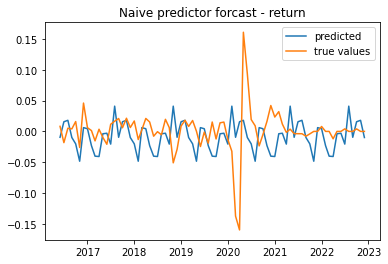

In [ ]:
plt.plot(test_df_ts1['date'], seas_output.values, label='predicted')
plt.plot(test_df_ts1['date'], test_df_ts1.value, label='true values')
plt.legend()
plt.title("Naive predictor forcast - return");

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
model_sarima = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
model_sarima.fit(train_df_ts1.value)
pred_sarima = model_sarima.predict(test_df_ts1.index)
# ваш код обучения моделей здесь

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
print(f"Mean absolute error of SARIMA: {np.round(mean_absolute_error(np.array(test_df_ts1.value), pred_sarima.values),3)}")

Mean absolute error of SARIMA: 0.019


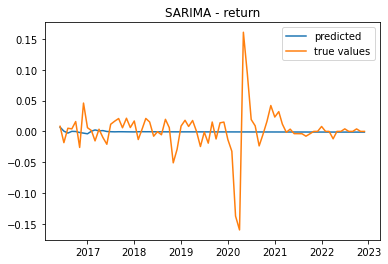

In [ ]:
plt.plot(test_df_ts1['date'], pred_sarima.values, label='predicted')
plt.plot(test_df_ts1['date'], test_df_ts1.value, label='true values')
plt.legend()
plt.title("SARIMA - return");

* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [ ]:
model_autosarima = AutoARIMA()
model_autosarima.fit(train_df_ts1.value)
pred_autosarima = forecaster.predict(test_df_ts1.index)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
print(f"Mean absolute error of AutoSARIMA: {np.round(mean_absolute_error(np.array(test_df_ts1.value), pred_autosarima[1]),3)}")

Mean absolute error of Auto SARIMA: 24.243


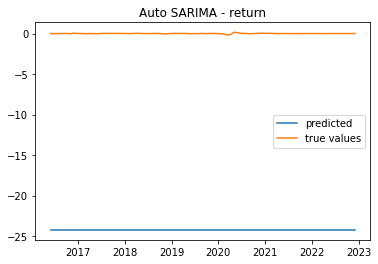

In [ ]:
plt.plot(test_df_ts1['date'], pred_autosarima[1].values, label='predicted')
plt.plot(test_df_ts1['date'], test_df_ts1.value, label='true values')
plt.legend()
plt.title("Auto SARIMA - return");

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models import LGT
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data

* DLT

In [ ]:
dltfull = DLT(response_col='value', date_col='date', seasonality=12, regressor_col=['price'], seed=8888)
dltfull.fit(df=train_df_ts1)
predicted_df = dltfull.predict(df=test_df_ts1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


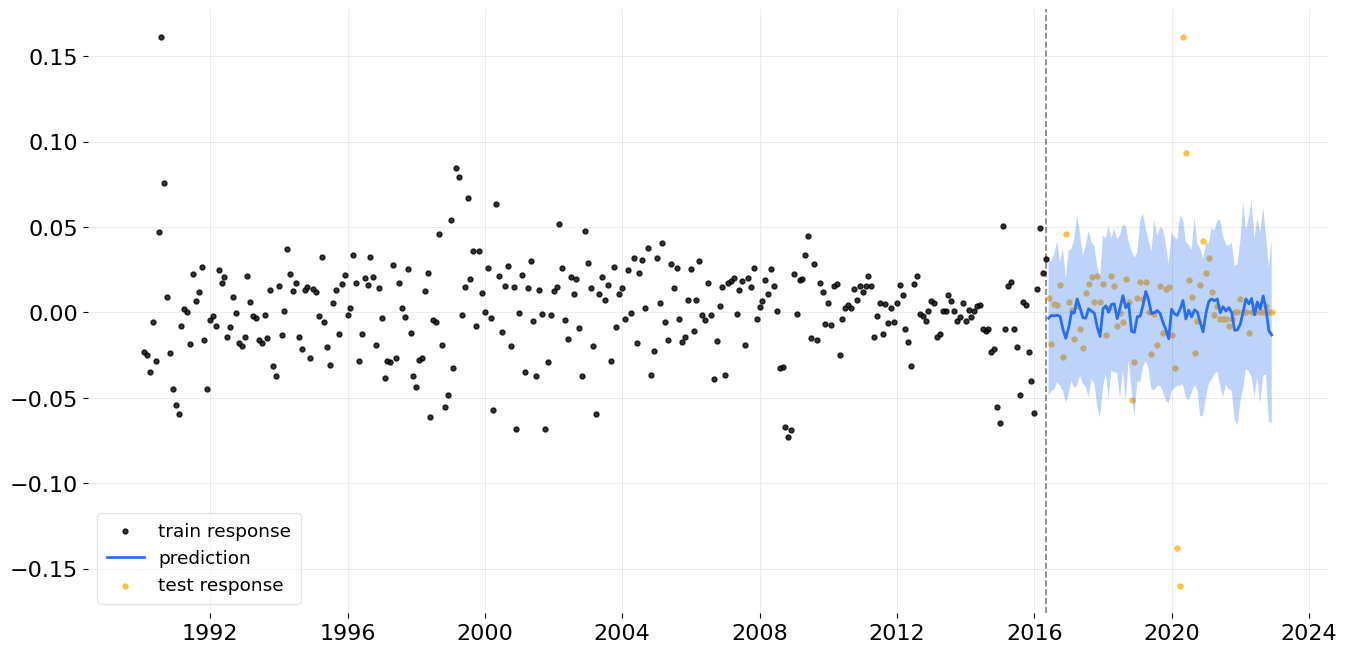

<AxesSubplot:>

In [ ]:
plot_predicted_data(
    training_actual_df=train_df_ts1, predicted_df=predicted_df,
    date_col=dltfull.date_col, actual_col=dltfull.response_col,
    test_actual_df=test_df_ts1
)

In [ ]:
print(f"Mean absolute error of DLT: {np.round(mean_absolute_error(np.array(test_df_ts1.value),predicted_df['prediction'].values),3)}")

Mean absolute error of DLT: 0.02


* LGT

In [ ]:
df = train_df_ts1_detrend
df_test = test_df_ts1_detrend

In [ ]:
# с семинара
train_df_ts1_detrend

lgtfull = LGT(
    response_col='level',
    date_col='date',
    seasonality=12,
    seed=8888
)

lgtfull.fit(df=df)

predicted_df = lgtfull.predict(df=df_test)

In [ ]:
pred_lgt = predicted_df['prediction'] + model_predict[-test_size_ts1:] # вернули обратно трендовую составляющую

In [ ]:
print(f"Mean absolute error of LGT: {np.round(mean_absolute_error(np.array(test_df_ts1.price),pred_lgt),3)}")

Mean absolute error of LGT: 26.907


### ETS (1 балл).

Обучите из библиотеки `sktime` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

In [ ]:
ETS = ExponentialSmoothing()
ETS.fit(train_df_ts1['value'])
y_pred_ets = ETS.predict(test_df_ts1.index)

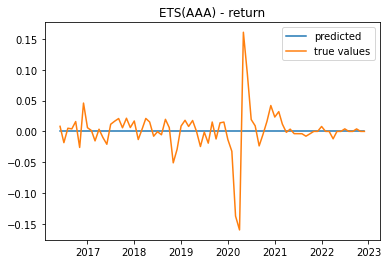

In [ ]:
plt.plot(test_df_ts1['date'], y_pred_ets.values, label='predicted')
plt.plot(test_df_ts1['date'], test_df_ts1.value, label='true values')
plt.legend()
plt.title("ETS(AAA) - return");

In [ ]:
print(f"Mean absolute error of DLT: {mean_absolute_error(np.array(test_df_ts1.value),y_pred_ets.values)}")

Mean absolute error of DLT: 0.018239624793620617


* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [ ]:
ETS_auto = AutoETS(trend='add', auto=True, information_criterion='aic')
ETS_auto.fit(train_df_ts1['value'])
y_pred_ets_auto = ETS_auto.predict(test_df_ts1.index)

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/ets.py:244: UserWarning: Warning: time series is not strictly positive,multiplicative components are ommitted
  "Warning: time series is not strictly positive,"


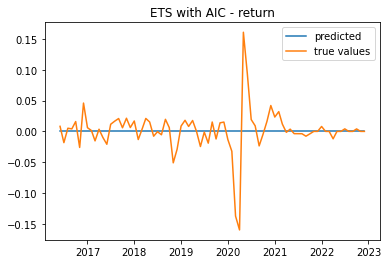

In [ ]:
plt.plot(test_df_ts1['date'], y_pred_ets_auto.values, label='predicted')
plt.plot(test_df_ts1['date'], test_df_ts1.value, label='true values')
plt.legend()
plt.title("ETS with AIC - return");

In [ ]:
print(f"Mean absolute error of DLT: {mean_absolute_error(np.array(test_df_ts1.value),y_pred_ets_auto.values)}")

Mean absolute error of DLT: 0.01823962671577015


Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

Модель DLT

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


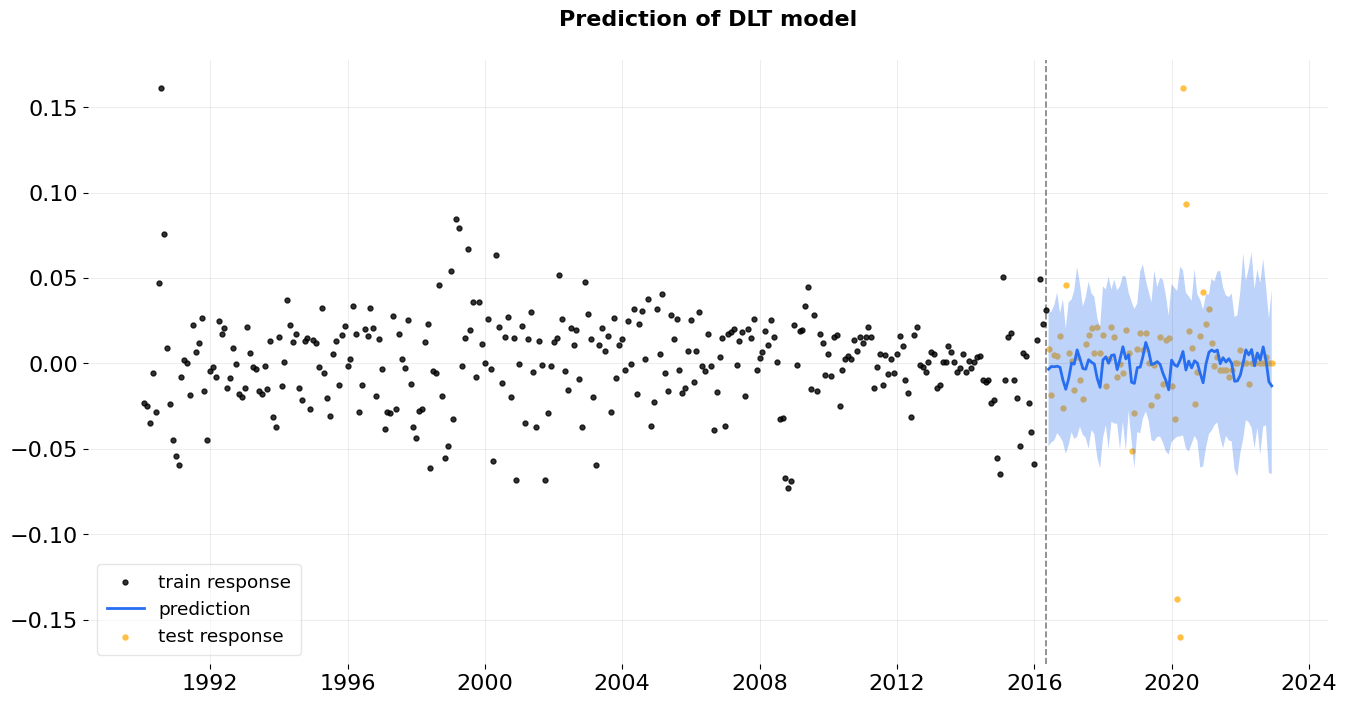

<AxesSubplot:title={'center':'Prediction of DLT model'}>

In [ ]:
# нарисуйте пресказания
dltfull = DLT(response_col='value', date_col='date', seasonality=12, regressor_col=['price'], seed=8888)
dltfull.fit(df=train_df_ts1)
predicted_df = dltfull.predict(df=test_df_ts1)

plot_predicted_data(
    training_actual_df=train_df_ts1, predicted_df=predicted_df,
    date_col=dltfull.date_col, actual_col=dltfull.response_col,
    test_actual_df=test_df_ts1, title='Prediction of DLT model'
)

In [ ]:
print(f"Mean absolute error of DLT: {mean_absolute_error(np.array(test_df_ts1.value),predicted_df['prediction'].values)}")

Mean absolute error of DLT: 0.019928187217698696


## Задание 4. Предсказание дневного временного ряда (3 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

In [ ]:
naive_ts2 = NaiveForecaster(strategy="last")
naive_ts2.fit(train_df_ts3.capacityLog)
naive_ts2_pred = naive_ts2.predict(test_df_ts3.index)

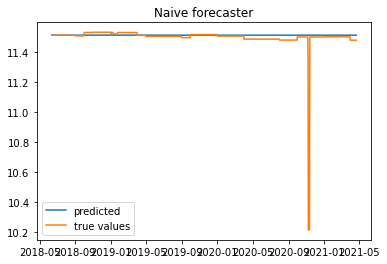

In [ ]:
plt.plot(test_df_ts3['date'], naive_ts2_pred.values, label='predicted')
plt.plot(test_df_ts3['date'], test_df_ts3.capacityLog, label='true values')
plt.legend()
plt.title("Naive forecaster");

In [ ]:
print(f"Mean absolute error of NaiveForcast: {mean_absolute_error(np.array(test_df_ts3.capacityLog),naive_ts2_pred.values)}")

Mean absolute error of NaiveForcaster: 0.019523978271572075


* $\hat{y}_{t+1} = y_{t-seasonality+1}$

Mean absolute error of Naive Seasonal Forecaster: 0.027597683332616176


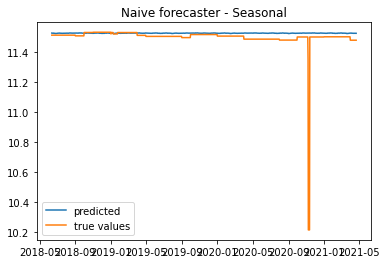

In [ ]:
naive_ts2_seas = NaiveForecaster(strategy="mean", sp=200)
naive_ts2_seas.fit(train_df_ts3.capacityLog)
naive_ts2_pred_seas = naive_ts2_seas.predict(test_df_ts3.index)

plt.plot(test_df_ts3['date'], naive_ts2_pred_seas.values, label='predicted')
plt.plot(test_df_ts3['date'], test_df_ts3.capacityLog, label='true values')
plt.legend()
plt.title("Naive forecaster - Seasonal");

print(f"Mean absolute error of Naive Seasonal Forecaster: {mean_absolute_error(np.array(test_df_ts3.capacityLog),naive_ts2_pred_seas.values)}")

### KTR из orbit (1 балл).



Использовался этот источник: https://orbit-ml.readthedocs.io/en/latest/tutorials/ktr1.html 

In [ ]:
from orbit.models import KTR
# ваш код обучения моделей здесь

In [ ]:
ktr = KTR(
    response_col="capacityLog",
    date_col="date",
    seed=2021
)
ktr.fit(train_df_ts3)
ktr_pred = ktr.predict(df=test_df_ts3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce583eb84b35032d795f7056cd3c761e NOW.
INFO:root:Guessed max_plate_nesting = 1


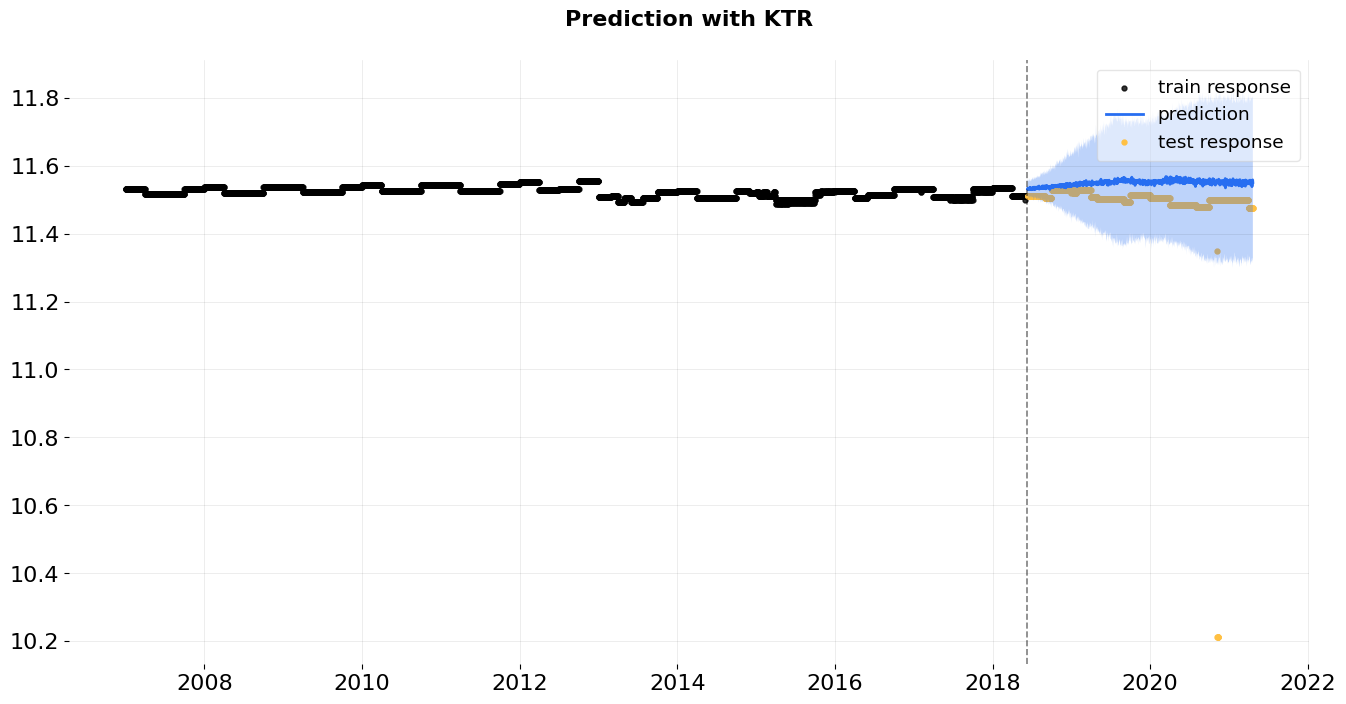

<AxesSubplot:title={'center':'Prediction with KTR'}>

In [ ]:
plot_predicted_data(training_actual_df=train_df_ts3, predicted_df=ktr_pred,
                    date_col=ktr.date_col, actual_col=ktr.response_col,
                    test_actual_df=test_df_ts3, title='Prediction with KTR')

In [ ]:
print(f"Mean absolute error of KTR: {mean_absolute_error(np.array(test_df_ts3.capacityLog),ktr_pred['prediction'].values)}")

Mean absolute error of KTR: 0.05166408781484672


### Phophet (1 балл).



In [ ]:
from prophet import Prophet

In [ ]:
prophet_ds = train_df_ts3.rename(columns={'date':'ds', 'capacityLog':'y'})

In [ ]:
prophet = Prophet(interval_width=0.95)
# никаких регрессоров добавить не можем
prophet.fit(prophet_ds)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prophet_ds_test = test_df_ts3.rename(columns={'date':'ds', 'capacityLog':'y'})

In [ ]:
prophet_pred = prophet.predict(prophet_ds_test)

In [ ]:
prophet_pred['yhat']

0       11.511319
1       11.511328
2       11.511331
3       11.511169
4       11.510261
          ...    
1040    11.509203
1041    11.509076
1042    11.509938
1043    11.510084
1044    11.510210
Name: yhat, Length: 1045, dtype: float64

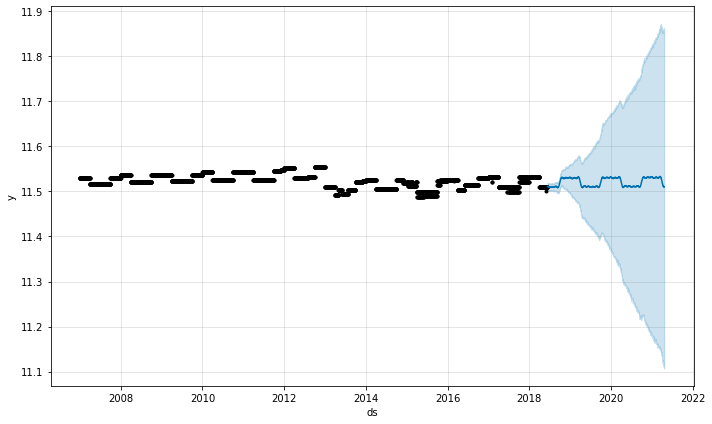

In [ ]:
fig1 = prophet.plot(prophet_pred)

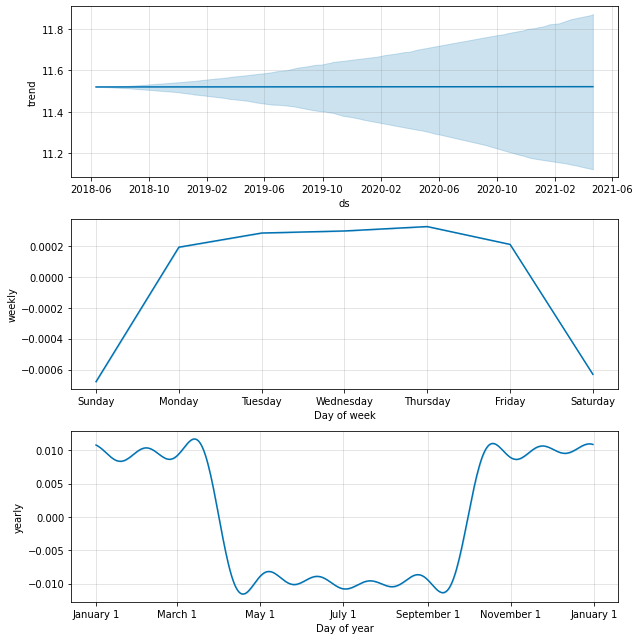

In [ ]:
fig2 = prophet.plot_components(prophet_pred)

In [ ]:
print(f"Mean absolute error of Prophet: {mean_absolute_error(np.array(test_df_ts3.capacityLog),prophet_pred['yhat'].values)}")

Mean absolute error of Prophet: 0.023792783497636097


Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

В случае этого ряда NaiveForecaster показывает лучшее качество по MAE

Mean absolute error of NaiveForcaster: 0.019523978271572075


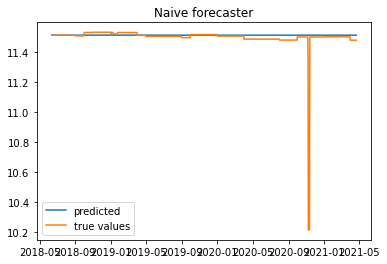

In [ ]:
plt.plot(test_df_ts3['date'], naive_ts2_pred.values, label='predicted')
plt.plot(test_df_ts3['date'], test_df_ts3.capacityLog, label='true values')
plt.legend()
plt.title("Naive forecaster");

print(f"Mean absolute error of NaiveForcaster: {mean_absolute_error(np.array(test_df_ts3.capacityLog),naive_ts2_pred.values)}")

## Задание 5. Предсказание временного ряда моделями машинного обучения (1 балл).

Возьмите один из ваших рядов, сформируйте по нему матрицу объект-признак и целевой вектор.

Разбейте данные на train/test в той же пропорции, что разбивали в заданиях выше.

Обучите различные классические модели машинного обучения и оцените их качество (MAE). 

Какая из моделей справилась с задачей предсказания лучше всего?

Использованные источники: https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1


Тк признаков кроме времени нет, будем использовать только его

In [ ]:
# обучите классические модели ML

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [49]:
X_train = train_df_ts1.drop(columns=["price"]).dropna()

In [51]:
X_train = X_train.drop(columns=["value"])

In [30]:
X_test = test_df_ts1.drop(columns=["price","value"]) 

In [39]:
y_train = train_df_ts1['value']
y_test = test_df_ts1['value']

In [44]:
y_train = y_train.dropna()

Random Forest

In [52]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_absolute_error',)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [57]:
print(f"Best Random Forest parameters: {best_model}", f"Best score of Random Forest: {np.round(-best_score,3)}", sep='\n')

Best Random Forest parameters: RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=20)
Best score of Random Forest: 0.02


In [61]:
rf_pred = gsearch.predict(X_test)

In [63]:
print(f"Mean absolute error of Random Forest: {np.round(mean_absolute_error(np.array(test_df_ts1.value),rf_pred),3)}")

Mean absolute error of Random Forest: 0.023


KNeighborsRegressor

In [64]:
from sklearn.neighbors import KNeighborsRegressor

In [66]:
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsRegressor()

In [68]:
kneigh = neigh.predict(X_test)

In [69]:
print(f"Mean absolute error of KNeighborsRegressor: {np.round(mean_absolute_error(np.array(test_df_ts1.value),kneigh),3)}")

Mean absolute error of KNeighborsRegressor: 0.021


Linear Regression

In [101]:
df_ts1 = ts1.dropna()

In [103]:
model_linear_ret = smf.ols('value ~ timeIndex', data = df_ts1).fit()

In [104]:
model_linear_ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.01556
Date:                Sat, 23 Apr 2022   Prob (F-statistic):              0.901
Time:                        22:02:15   Log-Likelihood:                 836.87
No. Observations:                 395   AIC:                            -1670.
Df Residuals:                     393   BIC:                            -1662.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0015      0.003      0.508      0.612      -0.004       0.007
timeIndex  -1.605e-06   1.29e-05     -0.125      0.901   -2.69e-05    2.37e-05
==============================================================================
Omnibus:                       68.639   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              934.272
Skew:                           0.051   Prob(JB):                    1.33e-203
Kurtosis:                      10.534   Cond. No.                         458.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
pred_model_linear_ret = model_linear_ret.predict()

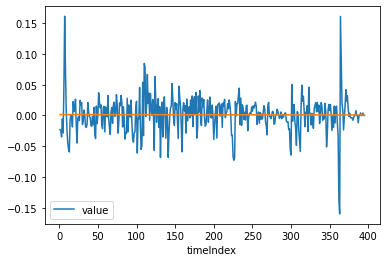

In [108]:
df_ts1.plot(kind="line", x="timeIndex", y = "value")
plt.plot(df_ts1.timeIndex,pred_model_linear_ret, '-');

In [112]:
print(f"MAE for Linear Regression: {mean_absolute_error(pred_model_linear_ret, df_ts1.value)}")

MAE for Linear Regression: 0.019763298436018508


На этом ряде методы машинного обучения так же дают схожие по качеству результаты